In [142]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Data Analysis and Exploration

In [23]:
f = open("parfums.json","r")
df = json.loads(f.read())
df_c = {}
for k in df:
    for c in df[k]:
        df_c[c] = df_c.get(c,[]) + [df[k][c]]

In [47]:
df

,nom,genre,contient,type
0,invictus-victory-elixir-de-paco-rabanne,man,oliban,Tête
1,invictus-victory-elixir-de-paco-rabanne,man,vanille,Coeur
2,invictus-victory-elixir-de-paco-rabanne,man,ambre,Coeur
3,invictus-victory-elixir-de-paco-rabanne,man,feve-tonka,Fond
4,la-petite-robe-noire-rose-cherry,woman,fleur-de-cerisier,Tête
...,...,...,...,...
15923,ambre-eternel,mixed,patchouli,Fond
15924,ambre-eternel,mixed,iris,Fond
15925,ambre-eternel,mixed,ambre-gris,Fond
15926,ambre-eternel,mixed,castoreum,Fond


In [29]:
df_contient = {
        "nom":[],
        "genre":[],
        "contient":[],
        "type":[]
}
for n,g,t,c,f in zip(df_c["nom"],df_c["genre"], df_c["Tête"], df_c["Coeur"],df_c["Fond"] ):
    
    for i in t:
        df_contient["nom"].append(n)
        df_contient["genre"].append(g)
        df_contient["contient"].append(i)
        df_contient["type"].append("Tête")

    for i in c:
        df_contient["nom"].append(n)
        df_contient["genre"].append(g)
        df_contient["contient"].append(i)
        df_contient["type"].append("Coeur")
        
    for i in f:
        df_contient["nom"].append(n)
        df_contient["genre"].append(g)
        df_contient["contient"].append(i)
        df_contient["type"].append("Fond")

In [56]:
df = pd.DataFrame(df_contient)
ingr_count = {}
for ingr in np.unique(df.contient.values):
    k = df[(df.type == "Tête") & (df.contient == ingr)].shape[0]
    ingr_count[ingr] = k

In [62]:
L = sorted(ingr_count.items(), key = lambda x:x[1], reverse=True)
np.unique(df.contient.values).shape

(327,)

# Training an auto-encoder

In [63]:

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, vector_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(vector_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, vector_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    

In [80]:
ingredients = json.loads(open("ingredients.json" ,"r").read())
parfums = json.loads(open("parfums.json" ,"r").read())

lexic = list(ingredients.keys())
lexic = sorted(lexic)

In [102]:
binary_desc = {}
for k in list(parfums.keys()):
    parfum_desc = parfums[k]
    binary_desc[parfum_desc["nom"]] = parfum_desc["Tête"] + parfum_desc["Coeur"] + parfum_desc["Fond"] 
    bin_v = np.zeros(len(lexic))
    for i in binary_desc[parfum_desc["nom"]]:
        bin_v[lexic.index(i)] = 1
    binary_desc[parfum_desc["nom"]] = bin_v


In [165]:
gender_dict = {}
for n,t in zip(df_c["nom"], df_c["genre"]):
    gender_dict[n] = t

In [110]:
class PerfumeDataset(torch.utils.data.Dataset):
    def __init__(self, bin_desc):
        self.names = list(bin_desc.keys())
        self.binary_desc = bin_desc


    def __len__(self):
        return len(self.binary_desc.keys())

    def __getitem__(self, index):
        # Return the image and its filename
        return self.binary_desc[self.names[index]]

In [111]:
dataset = PerfumeDataset(binary_desc)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [124]:

# Initialize the model, loss function, and optimizer
model = Autoencoder(327)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        inputs = torch.Tensor(data).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

Epoch [1/200], Loss: 0.2013
Epoch [2/200], Loss: 0.0853
Epoch [3/200], Loss: 0.0850
Epoch [4/200], Loss: 0.0849
Epoch [5/200], Loss: 0.0842
Epoch [6/200], Loss: 0.0834
Epoch [7/200], Loss: 0.0832
Epoch [8/200], Loss: 0.0831
Epoch [9/200], Loss: 0.0830
Epoch [10/200], Loss: 0.0826
Epoch [11/200], Loss: 0.0809
Epoch [12/200], Loss: 0.0796
Epoch [13/200], Loss: 0.0786
Epoch [14/200], Loss: 0.0775
Epoch [15/200], Loss: 0.0767
Epoch [16/200], Loss: 0.0762
Epoch [17/200], Loss: 0.0758
Epoch [18/200], Loss: 0.0755
Epoch [19/200], Loss: 0.0749
Epoch [20/200], Loss: 0.0742
Epoch [21/200], Loss: 0.0734
Epoch [22/200], Loss: 0.0731
Epoch [23/200], Loss: 0.0724
Epoch [24/200], Loss: 0.0718
Epoch [25/200], Loss: 0.0711
Epoch [26/200], Loss: 0.0703
Epoch [27/200], Loss: 0.0698
Epoch [28/200], Loss: 0.0693
Epoch [29/200], Loss: 0.0686
Epoch [30/200], Loss: 0.0682
Epoch [31/200], Loss: 0.0680
Epoch [32/200], Loss: 0.0674
Epoch [33/200], Loss: 0.0668
Epoch [34/200], Loss: 0.0667
Epoch [35/200], Loss: 0

In [100]:
def train_gan(gan, dataset, num_epochs=1000, batch_size=32, lr=0.001, noise_size = 0):
    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(gan.parameters(), lr=lr)
    
    # Create a tensor to store the labels for the real and fake data
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
    
    # Convert the dataset to a tensor
    dataset = torch.tensor(dataset, dtype=torch.float32)
    g_losses, d_losses =  [],[]
    
    # Start the training loop
    for epoch in range(num_epochs):
        # Sample a batch of real data
        idx = np.random.randint(0, len(dataset), batch_size)
        real_data = dataset[idx]
        
        # Generate a batch of fake data
        noise = torch.randn(batch_size, noise_size)
        fake_data = gan.generator(noise)
        
        # Train the discriminator on the real and fake data
        real_output = gan.discriminator(real_data)
        fake_output = gan.discriminator(fake_data.detach())
        d_loss = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)
        gan.discriminator.zero_grad()
        d_loss.backward()
        optimizer.step()
        
        # Train the generator
        noise = torch.randn(batch_size, noise_size)
        fake_data = gan.generator(noise)
        fake_output = gan.discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)
        gan.generator.zero_grad()
        g_loss.backward()
        optimizer.step()
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        # Print the loss for this epoch
        if epoch % 100 == 0:
            print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch, num_epochs, d_loss.item(), g_loss.item()))
    return g_losses, d_losses

dict_keys(['invictus-victory-elixir-de-paco-rabanne', 'la-petite-robe-noire-rose-cherry', 'aqua-allegoria-harvest-rosa-rossa'])

In [127]:
# Define the autoencoder model
class D2Autoencoder(nn.Module):
    def __init__(self, vector_size):
        super(D2Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(vector_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, vector_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [132]:
# Initialize the model, loss function, and optimizer
model = D2Autoencoder(327)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

num_epochs = 1000
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        inputs = torch.Tensor(data).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

Epoch [1/1000], Loss: 0.6758
Epoch [2/1000], Loss: 0.5799
Epoch [3/1000], Loss: 0.3159
Epoch [4/1000], Loss: 0.1105
Epoch [5/1000], Loss: 0.0912
Epoch [6/1000], Loss: 0.0880
Epoch [7/1000], Loss: 0.0866
Epoch [8/1000], Loss: 0.0858
Epoch [9/1000], Loss: 0.0853
Epoch [10/1000], Loss: 0.0850
Epoch [11/1000], Loss: 0.0848
Epoch [12/1000], Loss: 0.0846
Epoch [13/1000], Loss: 0.0845
Epoch [14/1000], Loss: 0.0844
Epoch [15/1000], Loss: 0.0842
Epoch [16/1000], Loss: 0.0840
Epoch [17/1000], Loss: 0.0837
Epoch [18/1000], Loss: 0.0832
Epoch [19/1000], Loss: 0.0829
Epoch [20/1000], Loss: 0.0827
Epoch [21/1000], Loss: 0.0826
Epoch [22/1000], Loss: 0.0825
Epoch [23/1000], Loss: 0.0824
Epoch [24/1000], Loss: 0.0822
Epoch [25/1000], Loss: 0.0817
Epoch [26/1000], Loss: 0.0805
Epoch [27/1000], Loss: 0.0790
Epoch [28/1000], Loss: 0.0781
Epoch [29/1000], Loss: 0.0774
Epoch [30/1000], Loss: 0.0768
Epoch [31/1000], Loss: 0.0763
Epoch [32/1000], Loss: 0.0759
Epoch [33/1000], Loss: 0.0755
Epoch [34/1000], Lo

In [176]:
points = []
genders = []
for k in list(binary_desc.keys())[:200]:
    b = torch.Tensor(binary_desc[k]).float()
    points.append(np.array(model.encoder(b).detach()))
    genders.append(gender_dict[k])
points = np.array(points)

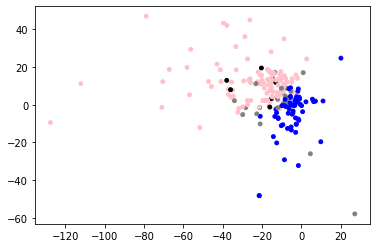

In [184]:
colors = {
    "man":"blue",
    "woman":"pink",
    "mixed":"grey",
    "unknown": "black",
}
plt.scatter(points[:, 0], points[:, 1], c = [colors[c] for c in genders],s = 15)
plt.savefig("embedding_gender.jpg")

In [256]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 300)
        self.fc2 = nn.Linear(300, 600)
        self.fc3 = nn.Linear(600, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.fc2 = nn.Linear(500, 600)
        self.fc3 = nn.Linear(600, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Define the GAN model
class GAN(nn.Module):
    def __init__(self, input_size, output_size):
        super(GAN, self).__init__()
        self.generator = Generator(input_size, output_size)
        self.discriminator = Discriminator(output_size)
        
    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x

In [260]:
gan = GAN(80, 327)
g_losses, d_losses = train_gan(gan, PerfumeDataset(binary_desc), num_epochs=100000, batch_size=64, lr=0.00001, noise_size=80)

Epoch [0/100000], d_loss: 1.4151, g_loss: 0.6672
Epoch [100/100000], d_loss: 1.1392, g_loss: 0.8733
Epoch [200/100000], d_loss: 1.0430, g_loss: 0.8111
Epoch [300/100000], d_loss: 0.8974, g_loss: 0.8545
Epoch [400/100000], d_loss: 0.8332, g_loss: 0.8169
Epoch [500/100000], d_loss: 0.8269, g_loss: 0.8268
Epoch [600/100000], d_loss: 0.8236, g_loss: 0.8609
Epoch [700/100000], d_loss: 0.7613, g_loss: 0.9158
Epoch [800/100000], d_loss: 0.7994, g_loss: 0.8275
Epoch [900/100000], d_loss: 0.8058, g_loss: 0.8675
Epoch [1000/100000], d_loss: 0.7648, g_loss: 0.8643
Epoch [1100/100000], d_loss: 0.6967, g_loss: 0.9106
Epoch [1200/100000], d_loss: 0.7217, g_loss: 0.8772
Epoch [1300/100000], d_loss: 0.6659, g_loss: 0.9130
Epoch [1400/100000], d_loss: 0.7110, g_loss: 0.8900
Epoch [1500/100000], d_loss: 0.6725, g_loss: 0.8576
Epoch [1600/100000], d_loss: 0.6661, g_loss: 0.8640
Epoch [1700/100000], d_loss: 0.6283, g_loss: 0.9108
Epoch [1800/100000], d_loss: 0.5770, g_loss: 0.9516
Epoch [1900/100000], d_l

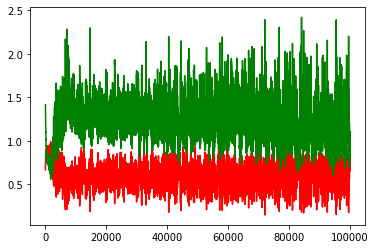

In [261]:
plt.plot(np.arange(len(g_losses)), g_losses, c = "red")
plt.plot(np.arange(len(d_losses)), d_losses, c = "green")
#plt.plot(np.arange(len(d_losses)), [max(i,g) for i,g in zip(d_losses, g_losses)], c = "yellow")

In [272]:
noise = torch.randn(64, 80)
fake_data = gan.generator(noise)
fake_data

tensor([[4.7948e-03, 3.0038e-03, 3.2337e-05,  ..., 2.3910e-04, 4.3484e-04,
         1.9762e-04],
        [9.8263e-03, 3.5678e-03, 1.4772e-04,  ..., 5.2539e-04, 7.9331e-04,
         8.3896e-04],
        [8.1994e-03, 4.5429e-03, 6.3329e-05,  ..., 5.7744e-04, 9.5809e-04,
         2.8663e-04],
        ...,
        [4.2433e-03, 3.3586e-03, 3.6532e-05,  ..., 4.7877e-04, 6.2363e-04,
         3.2877e-04],
        [6.0811e-03, 4.3612e-03, 8.3960e-05,  ..., 3.5406e-04, 1.0183e-03,
         2.5635e-04],
        [3.3966e-03, 4.4434e-03, 4.7672e-05,  ..., 3.3356e-04, 9.6987e-04,
         1.6143e-04]], grad_fn=<SigmoidBackward0>)